# CUSTOMER SEGMENTATION

## Import  Libraries 

In [33]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer,intercluster_distance
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import metrics
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)



## Data Preparation

I will create a wrangle fuction that will automate the data importation  and cleaning process.This ensures consistency in data preparationa and also helps in reusability

In [54]:
def wrangle(filepath):
    # read csv into DataFrame
    df = pd.read_csv(filepath,sep='\t')
    
    # dropping null values 
    df = df.dropna()
    
    # Feature Engineering
    # Calculate the present age of customer
    df["Age"] = 2021 - df["Year_Birth"]

    # Calculate the total spending on various items
    df["Spent"] = df[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]].sum(axis=1)

    # extracting living situation by marital status
    df["Living_With"] = df["Marital_Status"].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Alone", "Widow": "Alone", "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"})

    # Feature indicating total children living in the household
    df["Children"] = df["Kidhome"] + df["Teenhome"]

    # total members in the household
    df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner": 2}) + df["Children"]
    
    # website activity
    website_cols = ['NumWebPurchases', 'NumWebVisitsMonth']
    df['Website_Activity'] = df[website_cols].sum(axis=1)
    
    # Income ratio
    df['Income_Ratio'] = df['Total_Spending'] / df['Income']
    
    # total number of campaigns responded to by each customer
    response_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
    df['Campaign_Response'] = df[response_cols].sum(axis=1)

    # most frequent purchasing channel
    purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
    df['Purchasing_Channel'] = df[purchase_cols].idxmax(axis=1).str.replace('Num', '')
    
    # Feature pertaining to parenthood
    df["Is_Parent"] = (df["Children"] > 0).astype(int)

    # Stratifying education levels into three groups
    df["Education"] = df["Education"].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})

    # Dropping some redundant features
    to_drop = ['Year_Birth', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
        'Kidhome', 'Teenhome', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Dt_Customer',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'Response', 'Marital_Status', 'Education',
        'Z_CostContact', 'Z_Revenue', 'NumWebVisitsMonth', 'NumDealsPurchases'
    ]
    df = df.drop(to_drop, axis=1)
    
    # Calculate the IQR for 'Age' and 'Income'
    Q1_age = df['Age'].quantile(0.25)
    Q3_age = df['Age'].quantile(0.75)
    IQR_age = Q3_age - Q1_age

    Q1_income = df['Income'].quantile(0.25)
    Q3_income = df['Income'].quantile(0.75)
    IQR_income = Q3_income - Q1_income

    # Define the lower and upper bounds for outliers
    lower_bound_age = Q1_age - 1.5 * IQR_age
    upper_bound_age = Q3_age + 1.5 * IQR_age

    lower_bound_income = Q1_income - 1.5 * IQR_income
    upper_bound_income = Q3_income + 1.5 * IQR_income

    # Identify outliers
    outliers_age = df[(df['Age'] < lower_bound_age) | (df['Age'] > upper_bound_age)]
    outliers_income = df[(df['Income'] < lower_bound_income) | (df['Income'] > upper_bound_income)]

    # Count the number of outliers
    num_outliers_age = len(outliers_age)
    num_outliers_income = len(outliers_income)
    
    # Remove outliers from 'Age'
    df = df[(df['Age'] >= lower_bound_age) & (df['Age'] <= upper_bound_age)]

    # Remove outliers from 'Income'
    df = df[(df['Income'] >= lower_bound_income) & (df['Income'] <= upper_bound_income)]

    # Reset the index after removing rows
    df.reset_index(drop=True, inplace=True)

    
    return df
    

In [55]:
df = wrangle("Customer marketing.csv")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [12]:
# Adequate summary of the Data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Now I will comfirm the Dataset for null values 

In [13]:
# inspecting for null values 
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

From the above result the Feature (income) has 24 null values ,hence I will update the wrangle fuction to drop the null values. 

In [6]:
#confirming extradiction of null values
df.isnull().sum().any()
print('All null values have been eliminated.')

All null values have been eliminated.


In the upcoming phase, I will generate a new attribute based on "Dt_Customer" to signify the duration in days that a customer has been registered in the company's database. To simplify this, I will calculate this duration relative to the most recent customer entry in the dataset. Consequently, to obtain these values, I need to examine both the most recent and earliest recorded dates.

In [12]:
df["Customer_Registration_Date"] = pd.to_datetime(df["Dt_Customer"])

newest_date = df["Dt_Customer"].max().date()
oldest_date = df["Dt_Customer"].min().date()

print("The newest customer's enrolment date in the records:", newest_date)
print("The oldest customer's enrolment date in the records:", oldest_date)


The newest customer's enrolment date in the records: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


I'll generating a new attribute named "MembershipDuration" indicating the duration in days since customers began shopping in the store with reference to the most recent recorded date

In [13]:
# Calculate the number of days since each customer started shopping
df["MembershipDuration"] = (newest_date - df["Customer_Registration_Date"].dt.date).dt.days

# Ensure the "MembershipDuration" column contains numeric values
df["MembershipDuration"] = pd.to_numeric(df["MembershipDuration"], errors="coerce")


I'll now chect the Data for categorical Features

In [9]:
# Get the list of column names
columns = df.columns

# Initialize an empty list to store categorical column names
categorical_columns = []

# Iterate through each column and check if it has a data type of 'object' (categorical)
for col in columns:
    if df[col].dtype == 'object':
        categorical_columns.append(col)

# Iterate through categorical columns and print value counts
for cat_col in categorical_columns:
    print(f'\nValue counts for: {cat_col}\n')
    print(df[cat_col].value_counts())
    print('-' * 100)


Value counts for: Education

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64
----------------------------------------------------------------------------------------------------

Value counts for: Marital_Status

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64
----------------------------------------------------------------------------------------------------

Value counts for: Dt_Customer

31-08-2012    12
12-09-2012    11
14-02-2013    11
12-05-2014    11
20-08-2013    10
              ..
05-08-2012     1
18-11-2012     1
09-05-2014     1
26-06-2013     1
09-01-2014     1
Name: Dt_Customer, Length: 662, dtype: int64
----------------------------------------------------------------------------------------------------


In the following section, I will execute the following actions to generate new attributes:

* Derive the "Age" of each customer from their "Year_Birth," representing their birth year.
* Establish the "Spent" feature to summarize the total expenditure across various categories over a two-year period.
* Formulate the "Living_With" feature based on "Marital_Status" to describe the living arrangements of couples.
* Create a "Children" attribute to signify the total number of children within a household, encompassing both kids and teenagers.
* To gain a clearer picture of household composition, I will introduce a "Family_Size" feature.
* Establish the "Is_Parent" feature to denote whether a customer is a parent or not.
* I will simplify the "Education" category by categorizing it into three groups.
* The "Website_Activity" column represents the overall activity of customers on the company's website. It is calculated by summing up the columns "NumWebPurchases" and "NumWebVisitsMonth."
* Purchasing_Channel: The "Purchasing_Channel" column represents the most frequent purchasing channel used by each customer. It is determined by identifying   the column with the highest value among "NumWebPurchases," "NumCatalogPurchases," and "NumStorePurchases" and removing the "Num" prefix.
* Income_Ratio: The "Income_Ratio" column represents the ratio of total spending to income for each customer. It is calculated by dividing the "Total_Spending" column by the "Income" column.
* Campaign_Response: The "Campaign_Response" column reflects the cumulative count of campaigns to which each customer has responded. This value is derived by adding up the response columns, which include "AcceptedCmp1," "AcceptedCmp2," "AcceptedCmp3," "AcceptedCmp4," "AcceptedCmp5," and "Response."
* Remove redundant features as needed.

then I'll update the wrangle function with these engineeered attributes

In [56]:
# Feature Engineering
# Calculate the present age of customer
df["Age"] = 2021 - df["Year_Birth"]

# Calculate the total spending on various items
df["Spent"] = df[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]].sum(axis=1)

# extracting living situation by marital status
df["Living_With"] = df["Marital_Status"].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Alone", "Widow": "Alone", "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"})

# Feature indicating total children living in the household
df["Children"] = df["Kidhome"] + df["Teenhome"]

# total members in the household
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner": 2}) + df["Children"]

# most frequent purchasing channel
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Purchasing_Channel'] = df[purchase_cols].idxmax(axis=1).str.replace('Num', '')

# website activity
website_cols = ['NumWebPurchases', 'NumWebVisitsMonth']
df['Website_Activity'] = df[website_cols].sum(axis=1)

# Feature pertaining to parenthood
df["Is_Parent"] = (df["Children"] > 0).astype(int)

# Income ratio
df['Income_Ratio'] = df['Spent'] / df['Income']

# total number of campaigns responded to by each customer
response_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
df['Campaign_Response'] = df[response_cols].sum(axis=1)

# Stratifying education levels into three groups
df["Education"] = df["Education"].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})

# Dropping some redundant features
to_drop = ['Year_Birth', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'Kidhome', 'Teenhome', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Dt_Customer',
    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'Response', 'Marital_Status',
    'Z_CostContact', 'Z_Revenue', 'NumWebVisitsMonth', 'NumDealsPurchases'
]
df = df.drop(to_drop, axis=1)


Now i have updated the wrangle function lets inspect the new Data set .

In [57]:
# random samples of the dataset
df.sample(10)

,ID,Education,Income,Recency,Complain,Age,Spent,Living_With,Children,Family_Size,Purchasing_Channel,Website_Activity,Is_Parent,Income_Ratio,Campaign_Response
340,10172,Graduate,68655.0,95,0,33,1538,Alone,0,1,StorePurchases,7,0,0.022402,0
2107,340,Graduate,72967.0,1,0,51,497,Alone,1,2,StorePurchases,12,1,0.006811,2
1549,2217,Undergraduate,37284.0,46,0,46,23,Partner,2,4,StorePurchases,6,1,0.000617,0
427,8746,Graduate,75433.0,28,0,32,1188,Partner,1,3,StorePurchases,8,1,0.015749,2
2229,10084,Graduate,24434.0,9,0,49,50,Partner,2,4,WebPurchases,9,1,0.002046,0
1968,8537,Graduate,72643.0,60,0,72,1429,Alone,0,1,CatalogPurchases,5,0,0.019672,2
837,5687,Graduate,81702.0,98,0,41,1633,Alone,0,1,StorePurchases,10,0,0.019987,0
1009,6119,Postgraduate,36736.0,52,0,58,17,Alone,2,3,StorePurchases,7,1,0.000463,0
574,7369,Postgraduate,36959.0,56,0,40,62,Partner,1,3,StorePurchases,10,1,0.001678,0
1409,10010,Postgraduate,36957.0,43,0,68,152,Alone,2,3,WebPurchases,12,1,0.004113,1


In [58]:
# intricate summary
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  2216 non-null   int64  
 1   Education           2216 non-null   object 
 2   Income              2216 non-null   float64
 3   Recency             2216 non-null   int64  
 4   Complain            2216 non-null   int64  
 5   Age                 2216 non-null   int64  
 6   Spent               2216 non-null   int64  
 7   Living_With         2216 non-null   object 
 8   Children            2216 non-null   int64  
 9   Family_Size         2216 non-null   int64  
 10  Purchasing_Channel  2216 non-null   object 
 11  Website_Activity    2216 non-null   int64  
 12  Is_Parent           2216 non-null   int64  
 13  Income_Ratio        2216 non-null   float64
 14  Campaign_Response   2216 non-null   int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 277.0

In [41]:
#Generating Descriptive analysis on the Data
df.describe()

,ID,Income,Recency,Complain,Age,Spent,Children,Family_Size,Website_Activity,Is_Parent,Income_Ratio,Campaign_Response
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,5588.353339,52247.251354,49.012635,0.009477,52.179603,607.075361,0.947202,2.592509,9.404332,0.714350,0.009912,0.448556
std,3249.376275,25173.076661,28.948352,0.096907,11.985554,602.900476,0.749062,0.905722,3.565683,0.451825,0.016816,0.892440
min,0.000000,1730.000000,0.000000,0.000000,25.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000039,0.000000
25%,2814.750000,35303.000000,24.000000,0.000000,44.000000,69.000000,0.000000,2.000000,7.000000,0.000000,0.002346,0.000000
50%,5458.500000,51381.500000,49.000000,0.000000,51.000000,396.500000,1.000000,3.000000,9.000000,1.000000,0.008005,0.000000
75%,8421.750000,68522.000000,74.000000,0.000000,62.000000,1048.000000,1.000000,3.000000,11.000000,1.000000,0.015533,1.000000
max,11191.000000,666666.000000,99.000000,1.000000,128.000000,2525.000000,3.000000,5.000000,28.000000,1.000000,0.706988,5.000000


## Exploratory Analysis on Data set.

Now ill be creating visualizations for features .

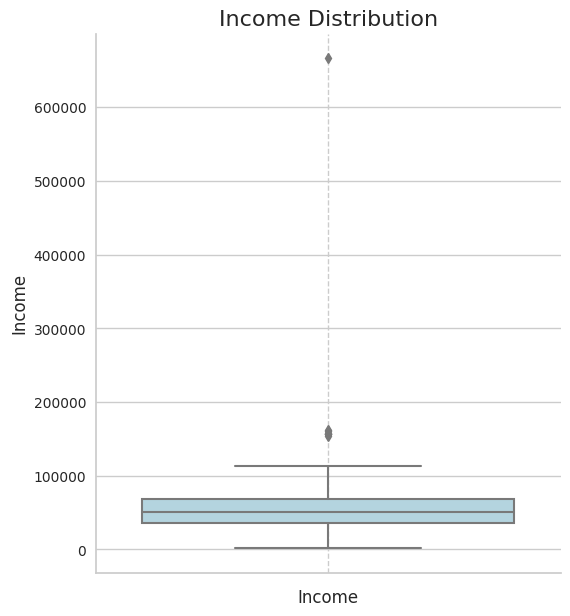

In [51]:
# Distribution of Income
plt.figure(figsize=[6, 7])
sns.boxplot(y=df['Income'], color='lightblue', linewidth=1.5)

plt.title('Income Distribution', fontsize=16)
plt.xlabel('Income', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--')

# Specify a font 
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

sns.despine()
plt.show()





From the above visualization it can be seen that there are outliers present in the income feature .

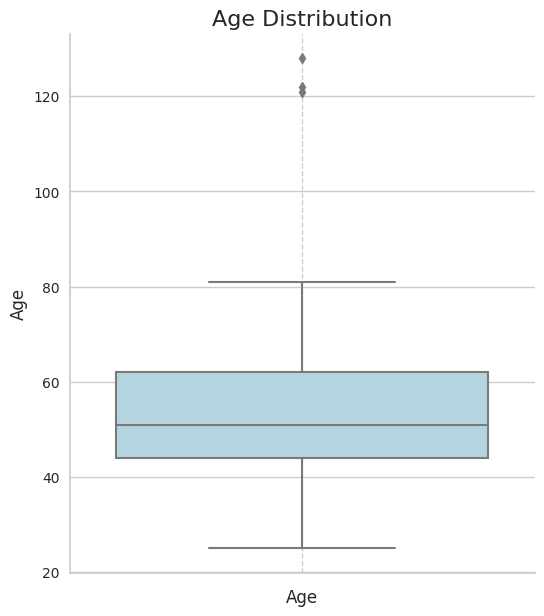

In [50]:
# Distribution of Age 
plt.figure(figsize=[6, 7])
sns.boxplot(y=df['Age'], color='lightblue', linewidth=1.5)

plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--')
sns.despine()
plt.show()


From the above visualization it can be deduced that there are outliers in the distribution of age

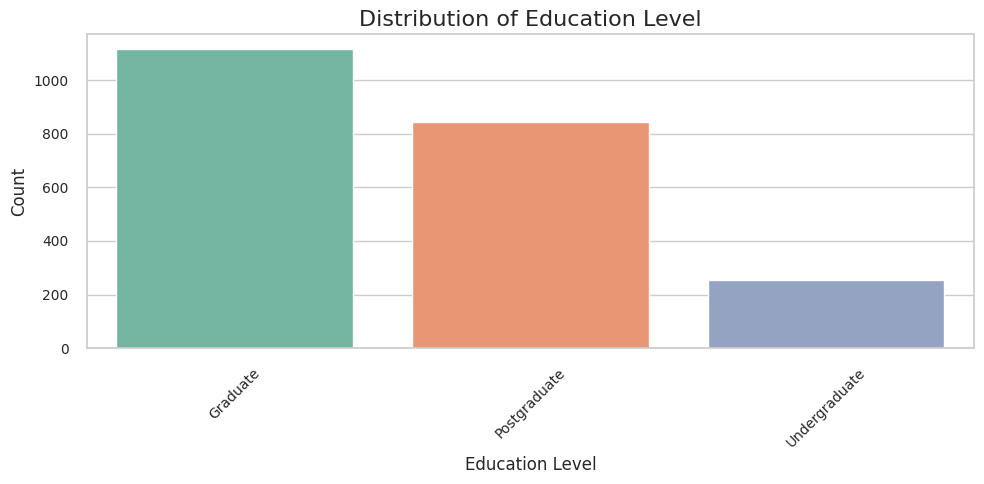

In [62]:
# Set the style for the plot
sns.set(style="whitegrid")

# Education_Level distribution with Seaborn
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Education", palette="Set2")

plt.title('Distribution of Education Level', fontsize=16)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

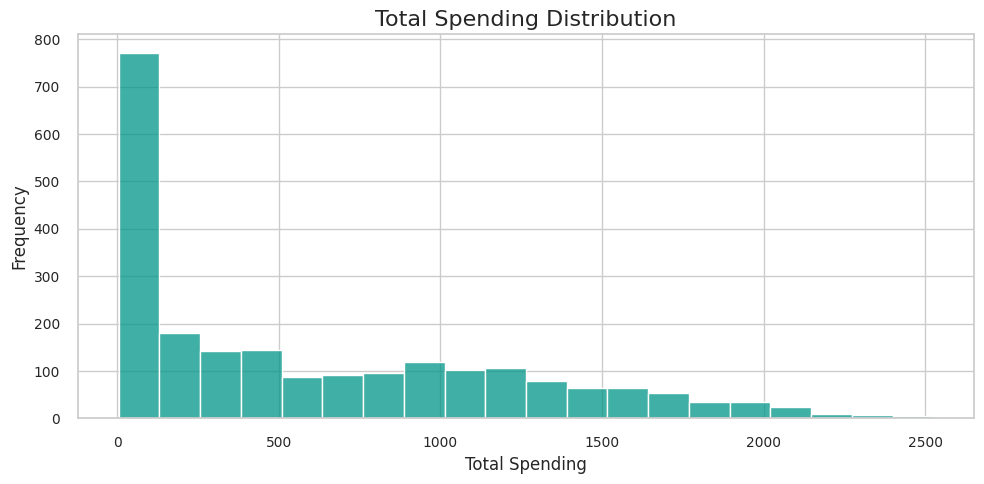

In [65]:

# Set the style for the plot
sns.set(style="whitegrid")

# Total spending distribution with Seaborn
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Spent', color='#009688', bins=20)

plt.title('Total Spending Distribution', fontsize=16)
plt.xlabel('Total Spending', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


From the above visualiaztion it can be seen that many customers spent arrroud the 0-500$ margin

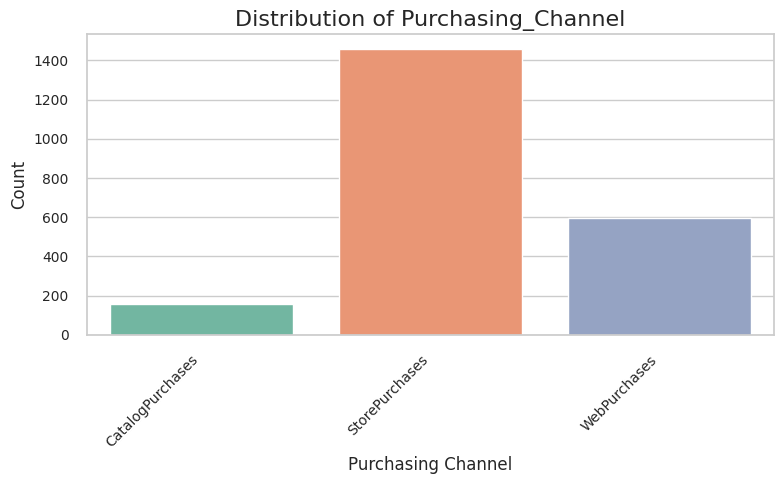

In [68]:
# Set the style for the plot
sns.set(style="whitegrid")

# Purchasing_Channel distribution with Seaborn
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Purchasing_Channel', palette='Set2')

plt.title('Distribution of Purchasing_Channel', fontsize=16)
plt.xlabel('Purchasing Channel', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


it can see that most purchases were made in the stores.

<Figure size 1000x700 with 0 Axes>

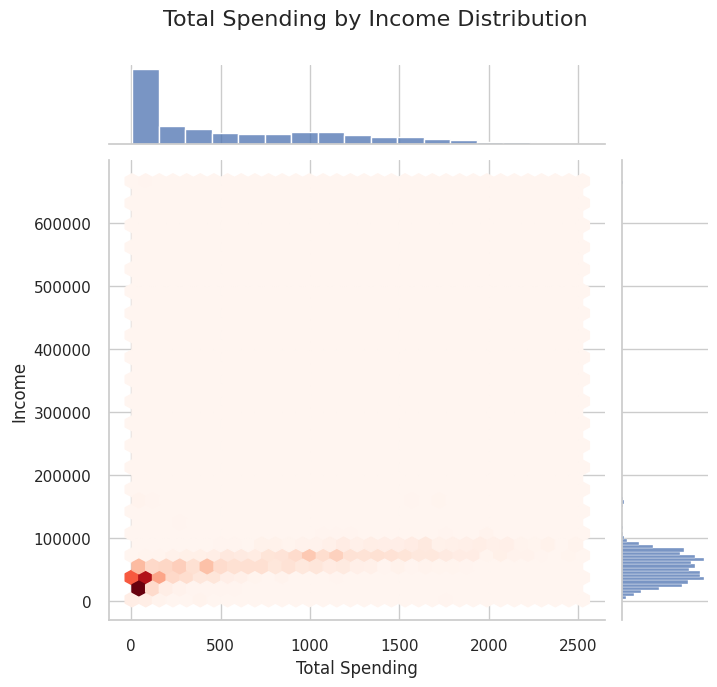

In [69]:
#Distribution of total amount spent with relation to income
# Create a hexbin plot
plt.figure(figsize=(10, 7))
sns.jointplot(data=df, x='Spent', y='Income', kind='hex', cmap='Reds', height=7)

plt.subplots_adjust(top=0.9)
plt.suptitle('Total Spending by Income Distribution', fontsize=16)
plt.xlabel('Total Spending', fontsize=12)
plt.ylabel('Income', fontsize=12)
plt.show()


We can see the distribution between total amount spent with relation to income 

Next ill identify the ouliers from age and income features 

In [70]:

# Calculate the IQR for 'Age' and 'Income'
Q1_age = df['Age'].quantile(0.25)
Q3_age = df['Age'].quantile(0.75)
IQR_age = Q3_age - Q1_age

Q1_income = df['Income'].quantile(0.25)
Q3_income = df['Income'].quantile(0.75)
IQR_income = Q3_income - Q1_income

# Define the lower and upper bounds for outliers
lower_bound_age = Q1_age - 1.5 * IQR_age
upper_bound_age = Q3_age + 1.5 * IQR_age

lower_bound_income = Q1_income - 1.5 * IQR_income
upper_bound_income = Q3_income + 1.5 * IQR_income

# Identify outliers
outliers_age = df[(df['Age'] < lower_bound_age) | (df['Age'] > upper_bound_age)]
outliers_income = df[(df['Income'] < lower_bound_income) | (df['Income'] > upper_bound_income)]

# Count the number of outliers
num_outliers_age = len(outliers_age)
num_outliers_income = len(outliers_income)

print(f'Number of outliers in Age: {num_outliers_age}')
print(f'Number of outliers in Income: {num_outliers_income}')


Number of outliers in Age: 3
Number of outliers in Income: 8


Now ive identified outliers, ill erradicate them .

In [71]:
# Remove outliers from 'Age'
df = df[(df['Age'] >= lower_bound_age) & (df['Age'] <= upper_bound_age)]

# Remove outliers from 'Income'
df = df[(df['Income'] >= lower_bound_income) & (df['Income'] <= upper_bound_income)]

# Reset the index after removing rows
df.reset_index(drop=True, inplace=True)


To comfirm the extradiction of the ouliers lets pot the features after which ill update my wrangle function with the code to remove outliers

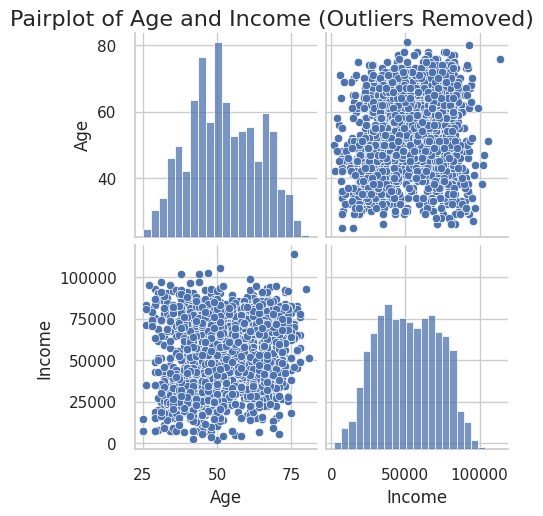

In [72]:
# pairplot to visualize 'Age' and 'Income' after removing outliers
sns.pairplot(df[['Age', 'Income']], height=2.5)
plt.suptitle("Pairplot of Age and Income (Outliers Removed)", y=1.02, fontsize=16)
plt.show()


In [73]:
#Cardinality check
df.select_dtypes("object").nunique()

Education             3
Living_With           2
Purchasing_Channel    3
dtype: int64

Finally, the last thing we need look out for is multicollinearity, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap and investigate the results.

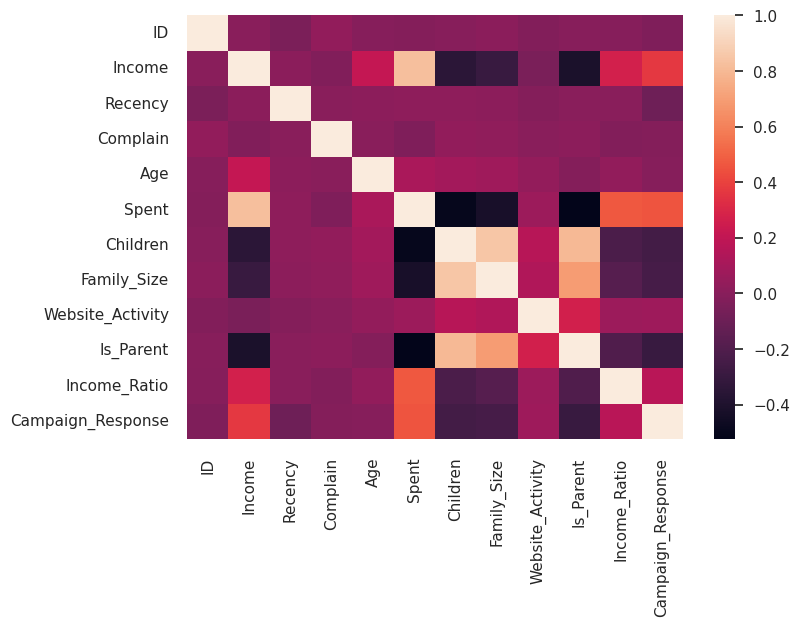

In [74]:
corr = df.select_dtypes("number").corr()
sns.heatmap(corr);